### Test the trained VPTR

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime
import time

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights, VPTRFormerFAR, VPTRFormerNAR
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training, write_code_files
from utils import set_seed, PSNR, SSIM, MSEScore, get_dataloader
import lpips
import numpy as np


from matplotlib import pyplot as plt

set_seed(2021)

In [11]:
resume_ckpt = Path('/home/ryukijano/VPTR_jigsaws/MovingMNIST/VPTR_ckpts/MNIST_FAR_MSEGDL_ckpt/epoch_11.tar') #The trained Transformer checkpoint file
resume_AE_ckpt = Path('/home/ryukijano/VPTR_jigsaws/checkpoints/epoch_6.tar') #The trained AutoEncoder checkpoint file
num_past_frames = 10
num_future_frames = 10
encH, encW, encC = 8, 8, 528
TSLMA_flag = False
rpe = True
model_flag = 'NAR' #'NAR' for NAR model, 'FAR' for FAR model

img_channels = 1 # 1 for KTH and MovingMNIST, 3 for BAIR
N = 16
device = torch.device('cuda:0')
loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'Dtotal', 'Dfake', 'Dreal']

In [12]:
#Set the padding_type to be "zero" for BAIR dataset
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'reflect').to(device) 

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid', padding_type = 'reflect').to(device) 
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

if model_flag == 'NAR':
    VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                         nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                         window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe=rpe).to(device)
else:
    VPTR_Transformer = VPTRFormerFAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                    nhead=8, num_encoder_layers=12, dropout=0.1, 
                                    window_size=4, Spatial_FFN_hidden_ratio=4, rpe=rpe).to(device)

VPTR_Transformer = VPTR_Transformer.eval()

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list)
if resume_ckpt is not None:
    loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
                                             {}, resume_ckpt, loss_name_list)

RuntimeError: Error(s) in loading state_dict for VPTRFormerNAR:
	Missing key(s) in state_dict: "frame_queries", "temporal_pos", "lw_pos", "Tlw_pos", "transformer.encoder.layers.0.SLMHSA.attn.relative_position_bias_table", "transformer.encoder.layers.0.SLMHSA.attn.relative_position_index", "transformer.encoder.layers.0.SLMHSA.attn.k_proj.weight", "transformer.encoder.layers.0.SLMHSA.attn.k_proj.bias", "transformer.encoder.layers.0.SLMHSA.attn.v_proj.weight", "transformer.encoder.layers.0.SLMHSA.attn.v_proj.bias", "transformer.encoder.layers.0.SLMHSA.attn.q_proj.weight", "transformer.encoder.layers.0.SLMHSA.attn.q_proj.bias", "transformer.encoder.layers.0.SLMHSA.attn.out_proj.weight", "transformer.encoder.layers.0.SLMHSA.attn.out_proj.bias", "transformer.encoder.layers.0.SpatialFFN.fc1.weight", "transformer.encoder.layers.0.SpatialFFN.fc1.bias", "transformer.encoder.layers.0.SpatialFFN.norm1.weight", "transformer.encoder.layers.0.SpatialFFN.norm1.bias", "transformer.encoder.layers.0.SpatialFFN.norm1.running_mean", "transformer.encoder.layers.0.SpatialFFN.norm1.running_var", "transformer.encoder.layers.0.SpatialFFN.dw3x3.weight", "transformer.encoder.layers.0.SpatialFFN.dw3x3.bias", "transformer.encoder.layers.0.SpatialFFN.norm2.weight", "transformer.encoder.layers.0.SpatialFFN.norm2.bias", "transformer.encoder.layers.0.SpatialFFN.norm2.running_mean", "transformer.encoder.layers.0.SpatialFFN.norm2.running_var", "transformer.encoder.layers.0.SpatialFFN.fc2.weight", "transformer.encoder.layers.0.SpatialFFN.fc2.bias", "transformer.encoder.layers.0.SpatialFFN.norm3.weight", "transformer.encoder.layers.0.SpatialFFN.norm3.bias", "transformer.encoder.layers.0.SpatialFFN.norm3.running_mean", "transformer.encoder.layers.0.SpatialFFN.norm3.running_var", "transformer.encoder.layers.0.norm1.weight", "transformer.encoder.layers.0.norm1.bias", "transformer.encoder.layers.0.norm2.weight", "transformer.encoder.layers.0.norm2.bias", "transformer.encoder.layers.0.norm3.weight", "transformer.encoder.layers.0.norm3.bias", "transformer.encoder.layers.0.temporal_MHSA.in_proj_weight", "transformer.encoder.layers.0.temporal_MHSA.in_proj_bias", "transformer.encoder.layers.0.temporal_MHSA.out_proj.weight", "transformer.encoder.layers.0.temporal_MHSA.out_proj.bias", "transformer.encoder.layers.0.linear1.weight", "transformer.encoder.layers.0.linear1.bias", "transformer.encoder.layers.0.linear2.weight", "transformer.encoder.layers.0.linear2.bias", "transformer.encoder.layers.0.norm4.weight", "transformer.encoder.layers.0.norm4.bias", "transformer.encoder.layers.1.SLMHSA.attn.relative_position_bias_table", "transformer.encoder.layers.1.SLMHSA.attn.relative_position_index", "transformer.encoder.layers.1.SLMHSA.attn.k_proj.weight", "transformer.encoder.layers.1.SLMHSA.attn.k_proj.bias", "transformer.encoder.layers.1.SLMHSA.attn.v_proj.weight", "transformer.encoder.layers.1.SLMHSA.attn.v_proj.bias", "transformer.encoder.layers.1.SLMHSA.attn.q_proj.weight", "transformer.encoder.layers.1.SLMHSA.attn.q_proj.bias", "transformer.encoder.layers.1.SLMHSA.attn.out_proj.weight", "transformer.encoder.layers.1.SLMHSA.attn.out_proj.bias", "transformer.encoder.layers.1.SpatialFFN.fc1.weight", "transformer.encoder.layers.1.SpatialFFN.fc1.bias", "transformer.encoder.layers.1.SpatialFFN.norm1.weight", "transformer.encoder.layers.1.SpatialFFN.norm1.bias", "transformer.encoder.layers.1.SpatialFFN.norm1.running_mean", "transformer.encoder.layers.1.SpatialFFN.norm1.running_var", "transformer.encoder.layers.1.SpatialFFN.dw3x3.weight", "transformer.encoder.layers.1.SpatialFFN.dw3x3.bias", "transformer.encoder.layers.1.SpatialFFN.norm2.weight", "transformer.encoder.layers.1.SpatialFFN.norm2.bias", "transformer.encoder.layers.1.SpatialFFN.norm2.running_mean", "transformer.encoder.layers.1.SpatialFFN.norm2.running_var", "transformer.encoder.layers.1.SpatialFFN.fc2.weight", "transformer.encoder.layers.1.SpatialFFN.fc2.bias", "transformer.encoder.layers.1.SpatialFFN.norm3.weight", "transformer.encoder.layers.1.SpatialFFN.norm3.bias", "transformer.encoder.layers.1.SpatialFFN.norm3.running_mean", "transformer.encoder.layers.1.SpatialFFN.norm3.running_var", "transformer.encoder.layers.1.norm1.weight", "transformer.encoder.layers.1.norm1.bias", "transformer.encoder.layers.1.norm2.weight", "transformer.encoder.layers.1.norm2.bias", "transformer.encoder.layers.1.norm3.weight", "transformer.encoder.layers.1.norm3.bias", "transformer.encoder.layers.1.temporal_MHSA.in_proj_weight", "transformer.encoder.layers.1.temporal_MHSA.in_proj_bias", "transformer.encoder.layers.1.temporal_MHSA.out_proj.weight", "transformer.encoder.layers.1.temporal_MHSA.out_proj.bias", "transformer.encoder.layers.1.linear1.weight", "transformer.encoder.layers.1.linear1.bias", "transformer.encoder.layers.1.linear2.weight", "transformer.encoder.layers.1.linear2.bias", "transformer.encoder.layers.1.norm4.weight", "transformer.encoder.layers.1.norm4.bias", "transformer.encoder.layers.2.SLMHSA.attn.relative_position_bias_table", "transformer.encoder.layers.2.SLMHSA.attn.relative_position_index", "transformer.encoder.layers.2.SLMHSA.attn.k_proj.weight", "transformer.encoder.layers.2.SLMHSA.attn.k_proj.bias", "transformer.encoder.layers.2.SLMHSA.attn.v_proj.weight", "transformer.encoder.layers.2.SLMHSA.attn.v_proj.bias", "transformer.encoder.layers.2.SLMHSA.attn.q_proj.weight", "transformer.encoder.layers.2.SLMHSA.attn.q_proj.bias", "transformer.encoder.layers.2.SLMHSA.attn.out_proj.weight", "transformer.encoder.layers.2.SLMHSA.attn.out_proj.bias", "transformer.encoder.layers.2.SpatialFFN.fc1.weight", "transformer.encoder.layers.2.SpatialFFN.fc1.bias", "transformer.encoder.layers.2.SpatialFFN.norm1.weight", "transformer.encoder.layers.2.SpatialFFN.norm1.bias", "transformer.encoder.layers.2.SpatialFFN.norm1.running_mean", "transformer.encoder.layers.2.SpatialFFN.norm1.running_var", "transformer.encoder.layers.2.SpatialFFN.dw3x3.weight", "transformer.encoder.layers.2.SpatialFFN.dw3x3.bias", "transformer.encoder.layers.2.SpatialFFN.norm2.weight", "transformer.encoder.layers.2.SpatialFFN.norm2.bias", "transformer.encoder.layers.2.SpatialFFN.norm2.running_mean", "transformer.encoder.layers.2.SpatialFFN.norm2.running_var", "transformer.encoder.layers.2.SpatialFFN.fc2.weight", "transformer.encoder.layers.2.SpatialFFN.fc2.bias", "transformer.encoder.layers.2.SpatialFFN.norm3.weight", "transformer.encoder.layers.2.SpatialFFN.norm3.bias", "transformer.encoder.layers.2.SpatialFFN.norm3.running_mean", "transformer.encoder.layers.2.SpatialFFN.norm3.running_var", "transformer.encoder.layers.2.norm1.weight", "transformer.encoder.layers.2.norm1.bias", "transformer.encoder.layers.2.norm2.weight", "transformer.encoder.layers.2.norm2.bias", "transformer.encoder.layers.2.norm3.weight", "transformer.encoder.layers.2.norm3.bias", "transformer.encoder.layers.2.temporal_MHSA.in_proj_weight", "transformer.encoder.layers.2.temporal_MHSA.in_proj_bias", "transformer.encoder.layers.2.temporal_MHSA.out_proj.weight", "transformer.encoder.layers.2.temporal_MHSA.out_proj.bias", "transformer.encoder.layers.2.linear1.weight", "transformer.encoder.layers.2.linear1.bias", "transformer.encoder.layers.2.linear2.weight", "transformer.encoder.layers.2.linear2.bias", "transformer.encoder.layers.2.norm4.weight", "transformer.encoder.layers.2.norm4.bias", "transformer.encoder.layers.3.SLMHSA.attn.relative_position_bias_table", "transformer.encoder.layers.3.SLMHSA.attn.relative_position_index", "transformer.encoder.layers.3.SLMHSA.attn.k_proj.weight", "transformer.encoder.layers.3.SLMHSA.attn.k_proj.bias", "transformer.encoder.layers.3.SLMHSA.attn.v_proj.weight", "transformer.encoder.layers.3.SLMHSA.attn.v_proj.bias", "transformer.encoder.layers.3.SLMHSA.attn.q_proj.weight", "transformer.encoder.layers.3.SLMHSA.attn.q_proj.bias", "transformer.encoder.layers.3.SLMHSA.attn.out_proj.weight", "transformer.encoder.layers.3.SLMHSA.attn.out_proj.bias", "transformer.encoder.layers.3.SpatialFFN.fc1.weight", "transformer.encoder.layers.3.SpatialFFN.fc1.bias", "transformer.encoder.layers.3.SpatialFFN.norm1.weight", "transformer.encoder.layers.3.SpatialFFN.norm1.bias", "transformer.encoder.layers.3.SpatialFFN.norm1.running_mean", "transformer.encoder.layers.3.SpatialFFN.norm1.running_var", "transformer.encoder.layers.3.SpatialFFN.dw3x3.weight", "transformer.encoder.layers.3.SpatialFFN.dw3x3.bias", "transformer.encoder.layers.3.SpatialFFN.norm2.weight", "transformer.encoder.layers.3.SpatialFFN.norm2.bias", "transformer.encoder.layers.3.SpatialFFN.norm2.running_mean", "transformer.encoder.layers.3.SpatialFFN.norm2.running_var", "transformer.encoder.layers.3.SpatialFFN.fc2.weight", "transformer.encoder.layers.3.SpatialFFN.fc2.bias", "transformer.encoder.layers.3.SpatialFFN.norm3.weight", "transformer.encoder.layers.3.SpatialFFN.norm3.bias", "transformer.encoder.layers.3.SpatialFFN.norm3.running_mean", "transformer.encoder.layers.3.SpatialFFN.norm3.running_var", "transformer.encoder.layers.3.norm1.weight", "transformer.encoder.layers.3.norm1.bias", "transformer.encoder.layers.3.norm2.weight", "transformer.encoder.layers.3.norm2.bias", "transformer.encoder.layers.3.norm3.weight", "transformer.encoder.layers.3.norm3.bias", "transformer.encoder.layers.3.temporal_MHSA.in_proj_weight", "transformer.encoder.layers.3.temporal_MHSA.in_proj_bias", "transformer.encoder.layers.3.temporal_MHSA.out_proj.weight", "transformer.encoder.layers.3.temporal_MHSA.out_proj.bias", "transformer.encoder.layers.3.linear1.weight", "transformer.encoder.layers.3.linear1.bias", "transformer.encoder.layers.3.linear2.weight", "transformer.encoder.layers.3.linear2.bias", "transformer.encoder.layers.3.norm4.weight", "transformer.encoder.layers.3.norm4.bias", "transformer.encoder.norm.weight", "transformer.encoder.norm.bias", "transformer.decoder.layers.0.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.0.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.0.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.0.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.0.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.0.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.0.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.0.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.0.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.0.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.0.SpatialFFN.fc1.weight", "transformer.decoder.layers.0.SpatialFFN.fc1.bias", "transformer.decoder.layers.0.SpatialFFN.norm1.weight", "transformer.decoder.layers.0.SpatialFFN.norm1.bias", "transformer.decoder.layers.0.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.0.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.0.SpatialFFN.norm2.weight", "transformer.decoder.layers.0.SpatialFFN.norm2.bias", "transformer.decoder.layers.0.SpatialFFN.fc2.weight", "transformer.decoder.layers.0.SpatialFFN.fc2.bias", "transformer.decoder.layers.0.SpatialFFN.norm3.weight", "transformer.decoder.layers.0.SpatialFFN.norm3.bias", "transformer.decoder.layers.0.norm1.weight", "transformer.decoder.layers.0.norm1.bias", "transformer.decoder.layers.0.norm2.weight", "transformer.decoder.layers.0.norm2.bias", "transformer.decoder.layers.0.norm3.weight", "transformer.decoder.layers.0.norm3.bias", "transformer.decoder.layers.0.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.0.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.0.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.0.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.0.linear1.weight", "transformer.decoder.layers.0.linear1.bias", "transformer.decoder.layers.0.linear2.weight", "transformer.decoder.layers.0.linear2.bias", "transformer.decoder.layers.0.norm4.weight", "transformer.decoder.layers.0.norm4.bias", "transformer.decoder.layers.0.EncDecAttn.in_proj_weight", "transformer.decoder.layers.0.EncDecAttn.in_proj_bias", "transformer.decoder.layers.0.EncDecAttn.out_proj.weight", "transformer.decoder.layers.0.EncDecAttn.out_proj.bias", "transformer.decoder.layers.0.SpatialFFN1.fc1.weight", "transformer.decoder.layers.0.SpatialFFN1.fc1.bias", "transformer.decoder.layers.0.SpatialFFN1.norm1.weight", "transformer.decoder.layers.0.SpatialFFN1.norm1.bias", "transformer.decoder.layers.0.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.0.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.0.SpatialFFN1.norm2.weight", "transformer.decoder.layers.0.SpatialFFN1.norm2.bias", "transformer.decoder.layers.0.SpatialFFN1.fc2.weight", "transformer.decoder.layers.0.SpatialFFN1.fc2.bias", "transformer.decoder.layers.0.SpatialFFN1.norm3.weight", "transformer.decoder.layers.0.SpatialFFN1.norm3.bias", "transformer.decoder.layers.0.norm5.weight", "transformer.decoder.layers.0.norm5.bias", "transformer.decoder.layers.0.norm6.weight", "transformer.decoder.layers.0.norm6.bias", "transformer.decoder.layers.1.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.1.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.1.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.1.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.1.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.1.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.1.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.1.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.1.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.1.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.1.SpatialFFN.fc1.weight", "transformer.decoder.layers.1.SpatialFFN.fc1.bias", "transformer.decoder.layers.1.SpatialFFN.norm1.weight", "transformer.decoder.layers.1.SpatialFFN.norm1.bias", "transformer.decoder.layers.1.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.1.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.1.SpatialFFN.norm2.weight", "transformer.decoder.layers.1.SpatialFFN.norm2.bias", "transformer.decoder.layers.1.SpatialFFN.fc2.weight", "transformer.decoder.layers.1.SpatialFFN.fc2.bias", "transformer.decoder.layers.1.SpatialFFN.norm3.weight", "transformer.decoder.layers.1.SpatialFFN.norm3.bias", "transformer.decoder.layers.1.norm1.weight", "transformer.decoder.layers.1.norm1.bias", "transformer.decoder.layers.1.norm2.weight", "transformer.decoder.layers.1.norm2.bias", "transformer.decoder.layers.1.norm3.weight", "transformer.decoder.layers.1.norm3.bias", "transformer.decoder.layers.1.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.1.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.1.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.1.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.1.linear1.weight", "transformer.decoder.layers.1.linear1.bias", "transformer.decoder.layers.1.linear2.weight", "transformer.decoder.layers.1.linear2.bias", "transformer.decoder.layers.1.norm4.weight", "transformer.decoder.layers.1.norm4.bias", "transformer.decoder.layers.1.EncDecAttn.in_proj_weight", "transformer.decoder.layers.1.EncDecAttn.in_proj_bias", "transformer.decoder.layers.1.EncDecAttn.out_proj.weight", "transformer.decoder.layers.1.EncDecAttn.out_proj.bias", "transformer.decoder.layers.1.SpatialFFN1.fc1.weight", "transformer.decoder.layers.1.SpatialFFN1.fc1.bias", "transformer.decoder.layers.1.SpatialFFN1.norm1.weight", "transformer.decoder.layers.1.SpatialFFN1.norm1.bias", "transformer.decoder.layers.1.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.1.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.1.SpatialFFN1.norm2.weight", "transformer.decoder.layers.1.SpatialFFN1.norm2.bias", "transformer.decoder.layers.1.SpatialFFN1.fc2.weight", "transformer.decoder.layers.1.SpatialFFN1.fc2.bias", "transformer.decoder.layers.1.SpatialFFN1.norm3.weight", "transformer.decoder.layers.1.SpatialFFN1.norm3.bias", "transformer.decoder.layers.1.norm5.weight", "transformer.decoder.layers.1.norm5.bias", "transformer.decoder.layers.1.norm6.weight", "transformer.decoder.layers.1.norm6.bias", "transformer.decoder.layers.2.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.2.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.2.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.2.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.2.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.2.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.2.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.2.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.2.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.2.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.2.SpatialFFN.fc1.weight", "transformer.decoder.layers.2.SpatialFFN.fc1.bias", "transformer.decoder.layers.2.SpatialFFN.norm1.weight", "transformer.decoder.layers.2.SpatialFFN.norm1.bias", "transformer.decoder.layers.2.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.2.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.2.SpatialFFN.norm2.weight", "transformer.decoder.layers.2.SpatialFFN.norm2.bias", "transformer.decoder.layers.2.SpatialFFN.fc2.weight", "transformer.decoder.layers.2.SpatialFFN.fc2.bias", "transformer.decoder.layers.2.SpatialFFN.norm3.weight", "transformer.decoder.layers.2.SpatialFFN.norm3.bias", "transformer.decoder.layers.2.norm1.weight", "transformer.decoder.layers.2.norm1.bias", "transformer.decoder.layers.2.norm2.weight", "transformer.decoder.layers.2.norm2.bias", "transformer.decoder.layers.2.norm3.weight", "transformer.decoder.layers.2.norm3.bias", "transformer.decoder.layers.2.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.2.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.2.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.2.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.2.linear1.weight", "transformer.decoder.layers.2.linear1.bias", "transformer.decoder.layers.2.linear2.weight", "transformer.decoder.layers.2.linear2.bias", "transformer.decoder.layers.2.norm4.weight", "transformer.decoder.layers.2.norm4.bias", "transformer.decoder.layers.2.EncDecAttn.in_proj_weight", "transformer.decoder.layers.2.EncDecAttn.in_proj_bias", "transformer.decoder.layers.2.EncDecAttn.out_proj.weight", "transformer.decoder.layers.2.EncDecAttn.out_proj.bias", "transformer.decoder.layers.2.SpatialFFN1.fc1.weight", "transformer.decoder.layers.2.SpatialFFN1.fc1.bias", "transformer.decoder.layers.2.SpatialFFN1.norm1.weight", "transformer.decoder.layers.2.SpatialFFN1.norm1.bias", "transformer.decoder.layers.2.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.2.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.2.SpatialFFN1.norm2.weight", "transformer.decoder.layers.2.SpatialFFN1.norm2.bias", "transformer.decoder.layers.2.SpatialFFN1.fc2.weight", "transformer.decoder.layers.2.SpatialFFN1.fc2.bias", "transformer.decoder.layers.2.SpatialFFN1.norm3.weight", "transformer.decoder.layers.2.SpatialFFN1.norm3.bias", "transformer.decoder.layers.2.norm5.weight", "transformer.decoder.layers.2.norm5.bias", "transformer.decoder.layers.2.norm6.weight", "transformer.decoder.layers.2.norm6.bias", "transformer.decoder.layers.3.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.3.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.3.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.3.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.3.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.3.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.3.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.3.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.3.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.3.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.3.SpatialFFN.fc1.weight", "transformer.decoder.layers.3.SpatialFFN.fc1.bias", "transformer.decoder.layers.3.SpatialFFN.norm1.weight", "transformer.decoder.layers.3.SpatialFFN.norm1.bias", "transformer.decoder.layers.3.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.3.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.3.SpatialFFN.norm2.weight", "transformer.decoder.layers.3.SpatialFFN.norm2.bias", "transformer.decoder.layers.3.SpatialFFN.fc2.weight", "transformer.decoder.layers.3.SpatialFFN.fc2.bias", "transformer.decoder.layers.3.SpatialFFN.norm3.weight", "transformer.decoder.layers.3.SpatialFFN.norm3.bias", "transformer.decoder.layers.3.norm1.weight", "transformer.decoder.layers.3.norm1.bias", "transformer.decoder.layers.3.norm2.weight", "transformer.decoder.layers.3.norm2.bias", "transformer.decoder.layers.3.norm3.weight", "transformer.decoder.layers.3.norm3.bias", "transformer.decoder.layers.3.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.3.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.3.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.3.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.3.linear1.weight", "transformer.decoder.layers.3.linear1.bias", "transformer.decoder.layers.3.linear2.weight", "transformer.decoder.layers.3.linear2.bias", "transformer.decoder.layers.3.norm4.weight", "transformer.decoder.layers.3.norm4.bias", "transformer.decoder.layers.3.EncDecAttn.in_proj_weight", "transformer.decoder.layers.3.EncDecAttn.in_proj_bias", "transformer.decoder.layers.3.EncDecAttn.out_proj.weight", "transformer.decoder.layers.3.EncDecAttn.out_proj.bias", "transformer.decoder.layers.3.SpatialFFN1.fc1.weight", "transformer.decoder.layers.3.SpatialFFN1.fc1.bias", "transformer.decoder.layers.3.SpatialFFN1.norm1.weight", "transformer.decoder.layers.3.SpatialFFN1.norm1.bias", "transformer.decoder.layers.3.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.3.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.3.SpatialFFN1.norm2.weight", "transformer.decoder.layers.3.SpatialFFN1.norm2.bias", "transformer.decoder.layers.3.SpatialFFN1.fc2.weight", "transformer.decoder.layers.3.SpatialFFN1.fc2.bias", "transformer.decoder.layers.3.SpatialFFN1.norm3.weight", "transformer.decoder.layers.3.SpatialFFN1.norm3.bias", "transformer.decoder.layers.3.norm5.weight", "transformer.decoder.layers.3.norm5.bias", "transformer.decoder.layers.3.norm6.weight", "transformer.decoder.layers.3.norm6.bias", "transformer.decoder.layers.4.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.4.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.4.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.4.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.4.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.4.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.4.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.4.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.4.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.4.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.4.SpatialFFN.fc1.weight", "transformer.decoder.layers.4.SpatialFFN.fc1.bias", "transformer.decoder.layers.4.SpatialFFN.norm1.weight", "transformer.decoder.layers.4.SpatialFFN.norm1.bias", "transformer.decoder.layers.4.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.4.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.4.SpatialFFN.norm2.weight", "transformer.decoder.layers.4.SpatialFFN.norm2.bias", "transformer.decoder.layers.4.SpatialFFN.fc2.weight", "transformer.decoder.layers.4.SpatialFFN.fc2.bias", "transformer.decoder.layers.4.SpatialFFN.norm3.weight", "transformer.decoder.layers.4.SpatialFFN.norm3.bias", "transformer.decoder.layers.4.norm1.weight", "transformer.decoder.layers.4.norm1.bias", "transformer.decoder.layers.4.norm2.weight", "transformer.decoder.layers.4.norm2.bias", "transformer.decoder.layers.4.norm3.weight", "transformer.decoder.layers.4.norm3.bias", "transformer.decoder.layers.4.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.4.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.4.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.4.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.4.linear1.weight", "transformer.decoder.layers.4.linear1.bias", "transformer.decoder.layers.4.linear2.weight", "transformer.decoder.layers.4.linear2.bias", "transformer.decoder.layers.4.norm4.weight", "transformer.decoder.layers.4.norm4.bias", "transformer.decoder.layers.4.EncDecAttn.in_proj_weight", "transformer.decoder.layers.4.EncDecAttn.in_proj_bias", "transformer.decoder.layers.4.EncDecAttn.out_proj.weight", "transformer.decoder.layers.4.EncDecAttn.out_proj.bias", "transformer.decoder.layers.4.SpatialFFN1.fc1.weight", "transformer.decoder.layers.4.SpatialFFN1.fc1.bias", "transformer.decoder.layers.4.SpatialFFN1.norm1.weight", "transformer.decoder.layers.4.SpatialFFN1.norm1.bias", "transformer.decoder.layers.4.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.4.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.4.SpatialFFN1.norm2.weight", "transformer.decoder.layers.4.SpatialFFN1.norm2.bias", "transformer.decoder.layers.4.SpatialFFN1.fc2.weight", "transformer.decoder.layers.4.SpatialFFN1.fc2.bias", "transformer.decoder.layers.4.SpatialFFN1.norm3.weight", "transformer.decoder.layers.4.SpatialFFN1.norm3.bias", "transformer.decoder.layers.4.norm5.weight", "transformer.decoder.layers.4.norm5.bias", "transformer.decoder.layers.4.norm6.weight", "transformer.decoder.layers.4.norm6.bias", "transformer.decoder.layers.5.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.5.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.5.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.5.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.5.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.5.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.5.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.5.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.5.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.5.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.5.SpatialFFN.fc1.weight", "transformer.decoder.layers.5.SpatialFFN.fc1.bias", "transformer.decoder.layers.5.SpatialFFN.norm1.weight", "transformer.decoder.layers.5.SpatialFFN.norm1.bias", "transformer.decoder.layers.5.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.5.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.5.SpatialFFN.norm2.weight", "transformer.decoder.layers.5.SpatialFFN.norm2.bias", "transformer.decoder.layers.5.SpatialFFN.fc2.weight", "transformer.decoder.layers.5.SpatialFFN.fc2.bias", "transformer.decoder.layers.5.SpatialFFN.norm3.weight", "transformer.decoder.layers.5.SpatialFFN.norm3.bias", "transformer.decoder.layers.5.norm1.weight", "transformer.decoder.layers.5.norm1.bias", "transformer.decoder.layers.5.norm2.weight", "transformer.decoder.layers.5.norm2.bias", "transformer.decoder.layers.5.norm3.weight", "transformer.decoder.layers.5.norm3.bias", "transformer.decoder.layers.5.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.5.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.5.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.5.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.5.linear1.weight", "transformer.decoder.layers.5.linear1.bias", "transformer.decoder.layers.5.linear2.weight", "transformer.decoder.layers.5.linear2.bias", "transformer.decoder.layers.5.norm4.weight", "transformer.decoder.layers.5.norm4.bias", "transformer.decoder.layers.5.EncDecAttn.in_proj_weight", "transformer.decoder.layers.5.EncDecAttn.in_proj_bias", "transformer.decoder.layers.5.EncDecAttn.out_proj.weight", "transformer.decoder.layers.5.EncDecAttn.out_proj.bias", "transformer.decoder.layers.5.SpatialFFN1.fc1.weight", "transformer.decoder.layers.5.SpatialFFN1.fc1.bias", "transformer.decoder.layers.5.SpatialFFN1.norm1.weight", "transformer.decoder.layers.5.SpatialFFN1.norm1.bias", "transformer.decoder.layers.5.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.5.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.5.SpatialFFN1.norm2.weight", "transformer.decoder.layers.5.SpatialFFN1.norm2.bias", "transformer.decoder.layers.5.SpatialFFN1.fc2.weight", "transformer.decoder.layers.5.SpatialFFN1.fc2.bias", "transformer.decoder.layers.5.SpatialFFN1.norm3.weight", "transformer.decoder.layers.5.SpatialFFN1.norm3.bias", "transformer.decoder.layers.5.norm5.weight", "transformer.decoder.layers.5.norm5.bias", "transformer.decoder.layers.5.norm6.weight", "transformer.decoder.layers.5.norm6.bias", "transformer.decoder.layers.6.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.6.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.6.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.6.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.6.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.6.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.6.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.6.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.6.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.6.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.6.SpatialFFN.fc1.weight", "transformer.decoder.layers.6.SpatialFFN.fc1.bias", "transformer.decoder.layers.6.SpatialFFN.norm1.weight", "transformer.decoder.layers.6.SpatialFFN.norm1.bias", "transformer.decoder.layers.6.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.6.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.6.SpatialFFN.norm2.weight", "transformer.decoder.layers.6.SpatialFFN.norm2.bias", "transformer.decoder.layers.6.SpatialFFN.fc2.weight", "transformer.decoder.layers.6.SpatialFFN.fc2.bias", "transformer.decoder.layers.6.SpatialFFN.norm3.weight", "transformer.decoder.layers.6.SpatialFFN.norm3.bias", "transformer.decoder.layers.6.norm1.weight", "transformer.decoder.layers.6.norm1.bias", "transformer.decoder.layers.6.norm2.weight", "transformer.decoder.layers.6.norm2.bias", "transformer.decoder.layers.6.norm3.weight", "transformer.decoder.layers.6.norm3.bias", "transformer.decoder.layers.6.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.6.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.6.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.6.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.6.linear1.weight", "transformer.decoder.layers.6.linear1.bias", "transformer.decoder.layers.6.linear2.weight", "transformer.decoder.layers.6.linear2.bias", "transformer.decoder.layers.6.norm4.weight", "transformer.decoder.layers.6.norm4.bias", "transformer.decoder.layers.6.EncDecAttn.in_proj_weight", "transformer.decoder.layers.6.EncDecAttn.in_proj_bias", "transformer.decoder.layers.6.EncDecAttn.out_proj.weight", "transformer.decoder.layers.6.EncDecAttn.out_proj.bias", "transformer.decoder.layers.6.SpatialFFN1.fc1.weight", "transformer.decoder.layers.6.SpatialFFN1.fc1.bias", "transformer.decoder.layers.6.SpatialFFN1.norm1.weight", "transformer.decoder.layers.6.SpatialFFN1.norm1.bias", "transformer.decoder.layers.6.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.6.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.6.SpatialFFN1.norm2.weight", "transformer.decoder.layers.6.SpatialFFN1.norm2.bias", "transformer.decoder.layers.6.SpatialFFN1.fc2.weight", "transformer.decoder.layers.6.SpatialFFN1.fc2.bias", "transformer.decoder.layers.6.SpatialFFN1.norm3.weight", "transformer.decoder.layers.6.SpatialFFN1.norm3.bias", "transformer.decoder.layers.6.norm5.weight", "transformer.decoder.layers.6.norm5.bias", "transformer.decoder.layers.6.norm6.weight", "transformer.decoder.layers.6.norm6.bias", "transformer.decoder.layers.7.SLMHSA.attn.relative_position_bias_table", "transformer.decoder.layers.7.SLMHSA.attn.relative_position_index", "transformer.decoder.layers.7.SLMHSA.attn.k_proj.weight", "transformer.decoder.layers.7.SLMHSA.attn.k_proj.bias", "transformer.decoder.layers.7.SLMHSA.attn.v_proj.weight", "transformer.decoder.layers.7.SLMHSA.attn.v_proj.bias", "transformer.decoder.layers.7.SLMHSA.attn.q_proj.weight", "transformer.decoder.layers.7.SLMHSA.attn.q_proj.bias", "transformer.decoder.layers.7.SLMHSA.attn.out_proj.weight", "transformer.decoder.layers.7.SLMHSA.attn.out_proj.bias", "transformer.decoder.layers.7.SpatialFFN.fc1.weight", "transformer.decoder.layers.7.SpatialFFN.fc1.bias", "transformer.decoder.layers.7.SpatialFFN.norm1.weight", "transformer.decoder.layers.7.SpatialFFN.norm1.bias", "transformer.decoder.layers.7.SpatialFFN.dw3x3.weight", "transformer.decoder.layers.7.SpatialFFN.dw3x3.bias", "transformer.decoder.layers.7.SpatialFFN.norm2.weight", "transformer.decoder.layers.7.SpatialFFN.norm2.bias", "transformer.decoder.layers.7.SpatialFFN.fc2.weight", "transformer.decoder.layers.7.SpatialFFN.fc2.bias", "transformer.decoder.layers.7.SpatialFFN.norm3.weight", "transformer.decoder.layers.7.SpatialFFN.norm3.bias", "transformer.decoder.layers.7.norm1.weight", "transformer.decoder.layers.7.norm1.bias", "transformer.decoder.layers.7.norm2.weight", "transformer.decoder.layers.7.norm2.bias", "transformer.decoder.layers.7.norm3.weight", "transformer.decoder.layers.7.norm3.bias", "transformer.decoder.layers.7.temporal_MHSA.in_proj_weight", "transformer.decoder.layers.7.temporal_MHSA.in_proj_bias", "transformer.decoder.layers.7.temporal_MHSA.out_proj.weight", "transformer.decoder.layers.7.temporal_MHSA.out_proj.bias", "transformer.decoder.layers.7.linear1.weight", "transformer.decoder.layers.7.linear1.bias", "transformer.decoder.layers.7.linear2.weight", "transformer.decoder.layers.7.linear2.bias", "transformer.decoder.layers.7.norm4.weight", "transformer.decoder.layers.7.norm4.bias", "transformer.decoder.layers.7.EncDecAttn.in_proj_weight", "transformer.decoder.layers.7.EncDecAttn.in_proj_bias", "transformer.decoder.layers.7.EncDecAttn.out_proj.weight", "transformer.decoder.layers.7.EncDecAttn.out_proj.bias", "transformer.decoder.layers.7.SpatialFFN1.fc1.weight", "transformer.decoder.layers.7.SpatialFFN1.fc1.bias", "transformer.decoder.layers.7.SpatialFFN1.norm1.weight", "transformer.decoder.layers.7.SpatialFFN1.norm1.bias", "transformer.decoder.layers.7.SpatialFFN1.dw3x3.weight", "transformer.decoder.layers.7.SpatialFFN1.dw3x3.bias", "transformer.decoder.layers.7.SpatialFFN1.norm2.weight", "transformer.decoder.layers.7.SpatialFFN1.norm2.bias", "transformer.decoder.layers.7.SpatialFFN1.fc2.weight", "transformer.decoder.layers.7.SpatialFFN1.fc2.bias", "transformer.decoder.layers.7.SpatialFFN1.norm3.weight", "transformer.decoder.layers.7.SpatialFFN1.norm3.bias", "transformer.decoder.layers.7.norm5.weight", "transformer.decoder.layers.7.norm5.bias", "transformer.decoder.layers.7.norm6.weight", "transformer.decoder.layers.7.norm6.bias", "transformer.decoder.norm.weight", "transformer.decoder.norm.bias", "NCE_projector.0.weight", "NCE_projector.0.bias", "NCE_projector.2.weight", "NCE_projector.2.bias". 
	Unexpected key(s) in state_dict: "l_pos", "", "rmer.encoder.layers.0.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.0.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.0.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.0.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.0.SpatialFFN.fc1.weight", "rmer.encoder.layers.0.SpatialFFN.fc1.bias", "rmer.encoder.layers.0.SpatialFFN.norm1.weight", "rmer.encoder.layers.0.SpatialFFN.norm1.bias", "rmer.encoder.layers.0.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.0.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.0.SpatialFFN.norm2.weight", "rmer.encoder.layers.0.SpatialFFN.norm2.bias", "rmer.encoder.layers.0.SpatialFFN.fc2.weight", "rmer.encoder.layers.0.SpatialFFN.fc2.bias", "rmer.encoder.layers.0.SpatialFFN.norm3.weight", "rmer.encoder.layers.0.SpatialFFN.norm3.bias", "rmer.encoder.layers.0.norm1.weight", "rmer.encoder.layers.0.norm1.bias", "rmer.encoder.layers.0.norm2.weight", "rmer.encoder.layers.0.norm2.bias", "rmer.encoder.layers.0.norm3.weight", "rmer.encoder.layers.0.norm3.bias", "rmer.encoder.layers.0.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.0.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.0.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.0.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.0.linear1.weight", "rmer.encoder.layers.0.linear1.bias", "rmer.encoder.layers.0.linear2.weight", "rmer.encoder.layers.0.linear2.bias", "rmer.encoder.layers.0.norm4.weight", "rmer.encoder.layers.0.norm4.bias", "rmer.encoder.layers.1.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.1.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.1.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.1.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.1.SpatialFFN.fc1.weight", "rmer.encoder.layers.1.SpatialFFN.fc1.bias", "rmer.encoder.layers.1.SpatialFFN.norm1.weight", "rmer.encoder.layers.1.SpatialFFN.norm1.bias", "rmer.encoder.layers.1.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.1.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.1.SpatialFFN.norm2.weight", "rmer.encoder.layers.1.SpatialFFN.norm2.bias", "rmer.encoder.layers.1.SpatialFFN.fc2.weight", "rmer.encoder.layers.1.SpatialFFN.fc2.bias", "rmer.encoder.layers.1.SpatialFFN.norm3.weight", "rmer.encoder.layers.1.SpatialFFN.norm3.bias", "rmer.encoder.layers.1.norm1.weight", "rmer.encoder.layers.1.norm1.bias", "rmer.encoder.layers.1.norm2.weight", "rmer.encoder.layers.1.norm2.bias", "rmer.encoder.layers.1.norm3.weight", "rmer.encoder.layers.1.norm3.bias", "rmer.encoder.layers.1.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.1.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.1.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.1.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.1.linear1.weight", "rmer.encoder.layers.1.linear1.bias", "rmer.encoder.layers.1.linear2.weight", "rmer.encoder.layers.1.linear2.bias", "rmer.encoder.layers.1.norm4.weight", "rmer.encoder.layers.1.norm4.bias", "rmer.encoder.layers.2.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.2.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.2.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.2.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.2.SpatialFFN.fc1.weight", "rmer.encoder.layers.2.SpatialFFN.fc1.bias", "rmer.encoder.layers.2.SpatialFFN.norm1.weight", "rmer.encoder.layers.2.SpatialFFN.norm1.bias", "rmer.encoder.layers.2.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.2.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.2.SpatialFFN.norm2.weight", "rmer.encoder.layers.2.SpatialFFN.norm2.bias", "rmer.encoder.layers.2.SpatialFFN.fc2.weight", "rmer.encoder.layers.2.SpatialFFN.fc2.bias", "rmer.encoder.layers.2.SpatialFFN.norm3.weight", "rmer.encoder.layers.2.SpatialFFN.norm3.bias", "rmer.encoder.layers.2.norm1.weight", "rmer.encoder.layers.2.norm1.bias", "rmer.encoder.layers.2.norm2.weight", "rmer.encoder.layers.2.norm2.bias", "rmer.encoder.layers.2.norm3.weight", "rmer.encoder.layers.2.norm3.bias", "rmer.encoder.layers.2.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.2.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.2.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.2.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.2.linear1.weight", "rmer.encoder.layers.2.linear1.bias", "rmer.encoder.layers.2.linear2.weight", "rmer.encoder.layers.2.linear2.bias", "rmer.encoder.layers.2.norm4.weight", "rmer.encoder.layers.2.norm4.bias", "rmer.encoder.layers.3.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.3.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.3.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.3.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.3.SpatialFFN.fc1.weight", "rmer.encoder.layers.3.SpatialFFN.fc1.bias", "rmer.encoder.layers.3.SpatialFFN.norm1.weight", "rmer.encoder.layers.3.SpatialFFN.norm1.bias", "rmer.encoder.layers.3.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.3.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.3.SpatialFFN.norm2.weight", "rmer.encoder.layers.3.SpatialFFN.norm2.bias", "rmer.encoder.layers.3.SpatialFFN.fc2.weight", "rmer.encoder.layers.3.SpatialFFN.fc2.bias", "rmer.encoder.layers.3.SpatialFFN.norm3.weight", "rmer.encoder.layers.3.SpatialFFN.norm3.bias", "rmer.encoder.layers.3.norm1.weight", "rmer.encoder.layers.3.norm1.bias", "rmer.encoder.layers.3.norm2.weight", "rmer.encoder.layers.3.norm2.bias", "rmer.encoder.layers.3.norm3.weight", "rmer.encoder.layers.3.norm3.bias", "rmer.encoder.layers.3.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.3.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.3.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.3.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.3.linear1.weight", "rmer.encoder.layers.3.linear1.bias", "rmer.encoder.layers.3.linear2.weight", "rmer.encoder.layers.3.linear2.bias", "rmer.encoder.layers.3.norm4.weight", "rmer.encoder.layers.3.norm4.bias", "rmer.encoder.layers.4.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.4.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.4.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.4.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.4.SpatialFFN.fc1.weight", "rmer.encoder.layers.4.SpatialFFN.fc1.bias", "rmer.encoder.layers.4.SpatialFFN.norm1.weight", "rmer.encoder.layers.4.SpatialFFN.norm1.bias", "rmer.encoder.layers.4.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.4.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.4.SpatialFFN.norm2.weight", "rmer.encoder.layers.4.SpatialFFN.norm2.bias", "rmer.encoder.layers.4.SpatialFFN.fc2.weight", "rmer.encoder.layers.4.SpatialFFN.fc2.bias", "rmer.encoder.layers.4.SpatialFFN.norm3.weight", "rmer.encoder.layers.4.SpatialFFN.norm3.bias", "rmer.encoder.layers.4.norm1.weight", "rmer.encoder.layers.4.norm1.bias", "rmer.encoder.layers.4.norm2.weight", "rmer.encoder.layers.4.norm2.bias", "rmer.encoder.layers.4.norm3.weight", "rmer.encoder.layers.4.norm3.bias", "rmer.encoder.layers.4.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.4.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.4.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.4.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.4.linear1.weight", "rmer.encoder.layers.4.linear1.bias", "rmer.encoder.layers.4.linear2.weight", "rmer.encoder.layers.4.linear2.bias", "rmer.encoder.layers.4.norm4.weight", "rmer.encoder.layers.4.norm4.bias", "rmer.encoder.layers.5.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.5.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.5.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.5.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.5.SpatialFFN.fc1.weight", "rmer.encoder.layers.5.SpatialFFN.fc1.bias", "rmer.encoder.layers.5.SpatialFFN.norm1.weight", "rmer.encoder.layers.5.SpatialFFN.norm1.bias", "rmer.encoder.layers.5.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.5.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.5.SpatialFFN.norm2.weight", "rmer.encoder.layers.5.SpatialFFN.norm2.bias", "rmer.encoder.layers.5.SpatialFFN.fc2.weight", "rmer.encoder.layers.5.SpatialFFN.fc2.bias", "rmer.encoder.layers.5.SpatialFFN.norm3.weight", "rmer.encoder.layers.5.SpatialFFN.norm3.bias", "rmer.encoder.layers.5.norm1.weight", "rmer.encoder.layers.5.norm1.bias", "rmer.encoder.layers.5.norm2.weight", "rmer.encoder.layers.5.norm2.bias", "rmer.encoder.layers.5.norm3.weight", "rmer.encoder.layers.5.norm3.bias", "rmer.encoder.layers.5.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.5.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.5.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.5.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.5.linear1.weight", "rmer.encoder.layers.5.linear1.bias", "rmer.encoder.layers.5.linear2.weight", "rmer.encoder.layers.5.linear2.bias", "rmer.encoder.layers.5.norm4.weight", "rmer.encoder.layers.5.norm4.bias", "rmer.encoder.layers.6.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.6.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.6.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.6.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.6.SpatialFFN.fc1.weight", "rmer.encoder.layers.6.SpatialFFN.fc1.bias", "rmer.encoder.layers.6.SpatialFFN.norm1.weight", "rmer.encoder.layers.6.SpatialFFN.norm1.bias", "rmer.encoder.layers.6.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.6.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.6.SpatialFFN.norm2.weight", "rmer.encoder.layers.6.SpatialFFN.norm2.bias", "rmer.encoder.layers.6.SpatialFFN.fc2.weight", "rmer.encoder.layers.6.SpatialFFN.fc2.bias", "rmer.encoder.layers.6.SpatialFFN.norm3.weight", "rmer.encoder.layers.6.SpatialFFN.norm3.bias", "rmer.encoder.layers.6.norm1.weight", "rmer.encoder.layers.6.norm1.bias", "rmer.encoder.layers.6.norm2.weight", "rmer.encoder.layers.6.norm2.bias", "rmer.encoder.layers.6.norm3.weight", "rmer.encoder.layers.6.norm3.bias", "rmer.encoder.layers.6.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.6.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.6.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.6.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.6.linear1.weight", "rmer.encoder.layers.6.linear1.bias", "rmer.encoder.layers.6.linear2.weight", "rmer.encoder.layers.6.linear2.bias", "rmer.encoder.layers.6.norm4.weight", "rmer.encoder.layers.6.norm4.bias", "rmer.encoder.layers.7.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.7.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.7.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.7.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.7.SpatialFFN.fc1.weight", "rmer.encoder.layers.7.SpatialFFN.fc1.bias", "rmer.encoder.layers.7.SpatialFFN.norm1.weight", "rmer.encoder.layers.7.SpatialFFN.norm1.bias", "rmer.encoder.layers.7.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.7.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.7.SpatialFFN.norm2.weight", "rmer.encoder.layers.7.SpatialFFN.norm2.bias", "rmer.encoder.layers.7.SpatialFFN.fc2.weight", "rmer.encoder.layers.7.SpatialFFN.fc2.bias", "rmer.encoder.layers.7.SpatialFFN.norm3.weight", "rmer.encoder.layers.7.SpatialFFN.norm3.bias", "rmer.encoder.layers.7.norm1.weight", "rmer.encoder.layers.7.norm1.bias", "rmer.encoder.layers.7.norm2.weight", "rmer.encoder.layers.7.norm2.bias", "rmer.encoder.layers.7.norm3.weight", "rmer.encoder.layers.7.norm3.bias", "rmer.encoder.layers.7.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.7.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.7.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.7.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.7.linear1.weight", "rmer.encoder.layers.7.linear1.bias", "rmer.encoder.layers.7.linear2.weight", "rmer.encoder.layers.7.linear2.bias", "rmer.encoder.layers.7.norm4.weight", "rmer.encoder.layers.7.norm4.bias", "rmer.encoder.layers.8.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.8.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.8.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.8.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.8.SpatialFFN.fc1.weight", "rmer.encoder.layers.8.SpatialFFN.fc1.bias", "rmer.encoder.layers.8.SpatialFFN.norm1.weight", "rmer.encoder.layers.8.SpatialFFN.norm1.bias", "rmer.encoder.layers.8.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.8.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.8.SpatialFFN.norm2.weight", "rmer.encoder.layers.8.SpatialFFN.norm2.bias", "rmer.encoder.layers.8.SpatialFFN.fc2.weight", "rmer.encoder.layers.8.SpatialFFN.fc2.bias", "rmer.encoder.layers.8.SpatialFFN.norm3.weight", "rmer.encoder.layers.8.SpatialFFN.norm3.bias", "rmer.encoder.layers.8.norm1.weight", "rmer.encoder.layers.8.norm1.bias", "rmer.encoder.layers.8.norm2.weight", "rmer.encoder.layers.8.norm2.bias", "rmer.encoder.layers.8.norm3.weight", "rmer.encoder.layers.8.norm3.bias", "rmer.encoder.layers.8.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.8.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.8.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.8.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.8.linear1.weight", "rmer.encoder.layers.8.linear1.bias", "rmer.encoder.layers.8.linear2.weight", "rmer.encoder.layers.8.linear2.bias", "rmer.encoder.layers.8.norm4.weight", "rmer.encoder.layers.8.norm4.bias", "rmer.encoder.layers.9.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.9.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.9.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.9.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.9.SpatialFFN.fc1.weight", "rmer.encoder.layers.9.SpatialFFN.fc1.bias", "rmer.encoder.layers.9.SpatialFFN.norm1.weight", "rmer.encoder.layers.9.SpatialFFN.norm1.bias", "rmer.encoder.layers.9.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.9.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.9.SpatialFFN.norm2.weight", "rmer.encoder.layers.9.SpatialFFN.norm2.bias", "rmer.encoder.layers.9.SpatialFFN.fc2.weight", "rmer.encoder.layers.9.SpatialFFN.fc2.bias", "rmer.encoder.layers.9.SpatialFFN.norm3.weight", "rmer.encoder.layers.9.SpatialFFN.norm3.bias", "rmer.encoder.layers.9.norm1.weight", "rmer.encoder.layers.9.norm1.bias", "rmer.encoder.layers.9.norm2.weight", "rmer.encoder.layers.9.norm2.bias", "rmer.encoder.layers.9.norm3.weight", "rmer.encoder.layers.9.norm3.bias", "rmer.encoder.layers.9.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.9.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.9.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.9.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.9.linear1.weight", "rmer.encoder.layers.9.linear1.bias", "rmer.encoder.layers.9.linear2.weight", "rmer.encoder.layers.9.linear2.bias", "rmer.encoder.layers.9.norm4.weight", "rmer.encoder.layers.9.norm4.bias", "rmer.encoder.layers.10.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.10.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.10.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.10.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.10.SpatialFFN.fc1.weight", "rmer.encoder.layers.10.SpatialFFN.fc1.bias", "rmer.encoder.layers.10.SpatialFFN.norm1.weight", "rmer.encoder.layers.10.SpatialFFN.norm1.bias", "rmer.encoder.layers.10.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.10.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.10.SpatialFFN.norm2.weight", "rmer.encoder.layers.10.SpatialFFN.norm2.bias", "rmer.encoder.layers.10.SpatialFFN.fc2.weight", "rmer.encoder.layers.10.SpatialFFN.fc2.bias", "rmer.encoder.layers.10.SpatialFFN.norm3.weight", "rmer.encoder.layers.10.SpatialFFN.norm3.bias", "rmer.encoder.layers.10.norm1.weight", "rmer.encoder.layers.10.norm1.bias", "rmer.encoder.layers.10.norm2.weight", "rmer.encoder.layers.10.norm2.bias", "rmer.encoder.layers.10.norm3.weight", "rmer.encoder.layers.10.norm3.bias", "rmer.encoder.layers.10.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.10.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.10.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.10.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.10.linear1.weight", "rmer.encoder.layers.10.linear1.bias", "rmer.encoder.layers.10.linear2.weight", "rmer.encoder.layers.10.linear2.bias", "rmer.encoder.layers.10.norm4.weight", "rmer.encoder.layers.10.norm4.bias", "rmer.encoder.layers.11.SLMHSA.attn.in_proj_weight", "rmer.encoder.layers.11.SLMHSA.attn.in_proj_bias", "rmer.encoder.layers.11.SLMHSA.attn.out_proj.weight", "rmer.encoder.layers.11.SLMHSA.attn.out_proj.bias", "rmer.encoder.layers.11.SpatialFFN.fc1.weight", "rmer.encoder.layers.11.SpatialFFN.fc1.bias", "rmer.encoder.layers.11.SpatialFFN.norm1.weight", "rmer.encoder.layers.11.SpatialFFN.norm1.bias", "rmer.encoder.layers.11.SpatialFFN.dw3x3.weight", "rmer.encoder.layers.11.SpatialFFN.dw3x3.bias", "rmer.encoder.layers.11.SpatialFFN.norm2.weight", "rmer.encoder.layers.11.SpatialFFN.norm2.bias", "rmer.encoder.layers.11.SpatialFFN.fc2.weight", "rmer.encoder.layers.11.SpatialFFN.fc2.bias", "rmer.encoder.layers.11.SpatialFFN.norm3.weight", "rmer.encoder.layers.11.SpatialFFN.norm3.bias", "rmer.encoder.layers.11.norm1.weight", "rmer.encoder.layers.11.norm1.bias", "rmer.encoder.layers.11.norm2.weight", "rmer.encoder.layers.11.norm2.bias", "rmer.encoder.layers.11.norm3.weight", "rmer.encoder.layers.11.norm3.bias", "rmer.encoder.layers.11.temporal_MHSA.in_proj_weight", "rmer.encoder.layers.11.temporal_MHSA.in_proj_bias", "rmer.encoder.layers.11.temporal_MHSA.out_proj.weight", "rmer.encoder.layers.11.temporal_MHSA.out_proj.bias", "rmer.encoder.layers.11.linear1.weight", "rmer.encoder.layers.11.linear1.bias", "rmer.encoder.layers.11.linear2.weight", "rmer.encoder.layers.11.linear2.bias", "rmer.encoder.layers.11.norm4.weight", "rmer.encoder.layers.11.norm4.bias", "rmer.encoder.norm.weight", "rmer.encoder.norm.bias". 

In [4]:
_, _, test_loader, renorm_transform = get_dataloader('MNIST', N, '/home/ryukijano/VPTR-main/VPTR-main/moving-mnist-example', test_past_frames = 10, test_future_frames = 10, ngpus = 1, num_workers = 1)

In [13]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    """
    Plot and save figure
    """
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')
    
def FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over Latent space, get a worse result
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = pred_feats[:, -1:, ...]
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over pixel space
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = VPTR_Enc(pred_future_frame)
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    NAR model inference function, for the case num_pred is divisible for the num_future_frames of training. e.g. num_pred = 20, num_future_frames = 10
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    past_gt_feats = VPTR_Enc(past_frames)
    
    for i in range(0, num_pred//VPTR_Transformer.num_future_frames):
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        if i == 0:
            pred_frames = VPTR_Dec(pred_future_feats)
        else:
            pred_frames = torch.cat([pred_frames, VPTR_Dec(pred_future_feats)], dim = 1)
        past_gt_feats = pred_future_feats
        
    
    return pred_frames, future_frames


def NAR_BAIR_2_to_28_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    Specifically for BAIR dataset, 2 -> 28 prediction.
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    #assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    pred = []
    #prediction 1
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    #prediction 2
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    
    #prediction 3
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames[:, 0:-2, ...])
    pred_frames = torch.cat(pred, dim = 1)
    
    return pred_frames, future_frames         

In [14]:

sample = next(iter(test_loader))
num_pred = 10
with torch.no_grad():
    pred_frames, gt_frames = FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


RuntimeError: The size of tensor a (10) must match the size of tensor b (9) at non-singleton dimension 0

In [15]:
sample = next(iter(test_loader))
num_pred = 10
with torch.no_grad():
    pred_frames, gt_frames = NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


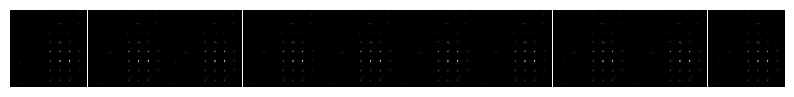

In [16]:
plot_model_result(pred_frames, 'pred_nar_mnist', 10, n = 5)

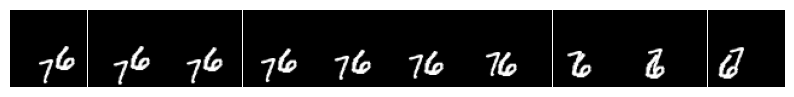

In [17]:
plot_model_result(gt_frames, 'gt_mnist', 10, n = 5)

In [18]:
import numpy as np
from utils import PSNR, SSIM
import lpips

def pred_ave_metrics(model, data_loader, metric_func, renorm_transform, num_future_frames, num_past_frames, device = 'cuda:0', use_lpips = False, gray_scale = True):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]
                
                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)
                    
                m = metric_func(pred_t, future_frames_t)*pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m
                
            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric